# Srinithish Kandagadla
# Assignment 3

In [171]:
from pyspark.sql import SparkSession

from pyspark import SparkConf, SparkContext
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
import numpy as np
import random
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pyspark
print(pyspark.__version__)
import re
from pyspark.ml.feature import CountVectorizer
import matplotlib.pyplot as plt
from math import log


2.4.4


In [172]:
spark = SparkSession.builder.master("local[*]").appName("Assign1").getOrCreate()    
spark.conf.set("spark.executor.memory", '30g')
spark.conf.set("spark.driver.memory",'30g')

### Part 1

In [173]:
AmazonDF = spark.read.csv("Amazon.csv",header=True,sep=",",inferSchema=True)
GoogleDF = spark.read.csv("Google.csv",header=True,sep=",",inferSchema=True)

### Part 2

#### (a) Implement a function that takes a string and returns non-empty tokens by splitting using regular expressions.


In [174]:
def tokenize(string,stopWordsList):
    
    words = re.split('\W+|\s|\.',string)
    
    words = [word for word in words if word not in stopWordsList and word != '']
    
    
    return words

tokenize('he hello know','')

['he', 'hello', 'know']

In [175]:
stopWordsList =  spark.read.csv("stopwords.txt",header=True,sep='\n',inferSchema=True).collect()
stopWordsList = [i['!!'] for i in stopWordsList]

In [176]:
GoogleDF = GoogleDF.filter(GoogleDF.description.isNotNull())
googleTokens = GoogleDF.select('id','description').rdd.map(lambda x: (x['id'],tokenize(x['description'],stopWordsList)))
googleTokensDf = spark.createDataFrame(googleTokens, ["id", "tokenised_description"])
googleTokensDf.show()

+--------------------+---------------------+
|                  id|tokenised_description|
+--------------------+---------------------+
|http://www.google...| [learning, quickb...|
|http://www.google...| [fun, reading, wr...|
|http://www.google...| [qb, pos, 6, 0, b...|
|http://www.google...| [save, spectacle,...|
|http://www.google...| [adobe, cs3, prod...|
|http://www.google...| [corel, video, st...|
|http://www.google...| [whether, working...|
|http://www.google...| [qb, pos, 6, 0, p...|
|http://www.google...| [quickbooks, cred...|
|http://www.google...| [sony, media, sof...|
|http://www.google...| [qb, pos, 6, 0, p...|
|http://www.google...| [decide, fate, ga...|
|http://www.google...| [based, tween, li...|
|http://www.google...| [cisco, systems, ...|
|http://www.google...| [wasp, bar, code,...|
|http://www.google...| [axis, communicat...|
|http://www.google...| [hp, eu063av, aba...|
|http://www.google...| [ibm, bb0gyna, us...|
|http://www.google...| [equisys, eqzfn07...|
|http://ww

In [177]:
AmazonDF = AmazonDF.filter(AmazonDF.description.isNotNull())
amazonTokens = AmazonDF.select('id','description').rdd.map(lambda x: (x['id'],tokenize(x['description'],stopWordsList)))
amazonTokensDf = spark.createDataFrame(amazonTokens, ["id", "tokenised_description"])
amazonTokensDf.show()

+----------+---------------------+
|        id|tokenised_description|
+----------+---------------------+
|b0006zf55o| [oem, arcserve, b...|
|b000g80lqo| [peachtree, premi...|
|b0006se5bq| [singing, coach, ...|
|b000ehpzv8| [emc, retrospect,...|
|b00021xhzw| [upgrade, install...|
|b000gzwjgc| [marketing, infor...|
|b0000dbykm| [mia, s, math, ad...|
|b00029bqa2| [disney, s, 1st, ...|
|b0007prnjo| [many, times, hea...|
|b000aazr5i| [marketing, infor...|
|b000bhl1r8| [sql, server, com...|
|b00006hmwc| [reference, domin...|
|b00006hvvo| [today, enterpris...|
|b0000ycfcw| [topics, presents...|
|b00002sac9| [now, featuring, ...|
|b000bcz8ng| [world, book, enc...|
|b000fm18vi| [chord, display, ...|
|b00009apna| [complete, easy, ...|
|b0009rgzgm| [use, computer, r...|
|b000o24l3q| [note, upgrade, v...|
+----------+---------------------+
only showing top 20 rows



### Part 3

In [178]:
from collections import Counter



def getTermFrequency(inpList):
    freqDict = Counter(inpList)
    return dict(freqDict)


googleTermFreq=googleTokens.map(lambda x:(x[0],getTermFrequency(x[1])))
googleTermFreq = spark.createDataFrame(googleTermFreq, ["id", "value"])
googleTermFreq.show(3)


+--------------------+--------------------+
|                  id|               value|
+--------------------+--------------------+
|http://www.google...|[quickbooks -> 1,...|
|http://www.google...|[solving -> 1, re...|
|http://www.google...|[retailers -> 1, ...|
+--------------------+--------------------+
only showing top 3 rows



In [179]:
amazonTermFreq=amazonTokens.map(lambda x:(x[0],getTermFrequency(x[1])))
amazonTermFreq = spark.createDataFrame(amazonTermFreq, ["id", "value"])
amazonTermFreq.show(3)

+----------+--------------------+
|        id|               value|
+----------+--------------------+
|b0006zf55o|[1 -> 1, arcserve...|
|b000g80lqo|[year -> 1, advan...|
|b0006se5bq|[singing -> 1, nt...|
+----------+--------------------+
only showing top 3 rows



#### Using HashingTF and IDF functions 

In [180]:
hashingTF = HashingTF(inputCol="tokenised_description", outputCol="tf_Features")
featurizedData = hashingTF.transform(amazonTokensDf)
featurizedData.show()

+----------+---------------------+--------------------+
|        id|tokenised_description|         tf_Features|
+----------+---------------------+--------------------+
|b0006zf55o| [oem, arcserve, b...|(262144,[39881,55...|
|b000g80lqo| [peachtree, premi...|(262144,[15,9886,...|
|b0006se5bq| [singing, coach, ...|(262144,[47491,59...|
|b000ehpzv8| [emc, retrospect,...|(262144,[13087,63...|
|b00021xhzw| [upgrade, install...|(262144,[15,353,4...|
|b000gzwjgc| [marketing, infor...|(262144,[329,1879...|
|b0000dbykm| [mia, s, math, ad...|(262144,[19492,19...|
|b00029bqa2| [disney, s, 1st, ...|(262144,[20495,21...|
|b0007prnjo| [many, times, hea...|(262144,[1998,578...|
|b000aazr5i| [marketing, infor...|(262144,[573,2437...|
|b000bhl1r8| [sql, server, com...|(262144,[966,1799...|
|b00006hmwc| [reference, domin...|(262144,[15013,17...|
|b00006hvvo| [today, enterpris...|(262144,[15,4525,...|
|b0000ycfcw| [topics, presents...|(262144,[30425,34...|
|b00002sac9| [now, featuring, ...|(262144,[413,5

In [181]:
idf = IDF(inputCol="tf_Features", outputCol="idf_features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [182]:
rescaledData.show()

+----------+---------------------+--------------------+--------------------+
|        id|tokenised_description|         tf_Features|        idf_features|
+----------+---------------------+--------------------+--------------------+
|b0006zf55o| [oem, arcserve, b...|(262144,[39881,55...|(262144,[39881,55...|
|b000g80lqo| [peachtree, premi...|(262144,[15,9886,...|(262144,[15,9886,...|
|b0006se5bq| [singing, coach, ...|(262144,[47491,59...|(262144,[47491,59...|
|b000ehpzv8| [emc, retrospect,...|(262144,[13087,63...|(262144,[13087,63...|
|b00021xhzw| [upgrade, install...|(262144,[15,353,4...|(262144,[15,353,4...|
|b000gzwjgc| [marketing, infor...|(262144,[329,1879...|(262144,[329,1879...|
|b0000dbykm| [mia, s, math, ad...|(262144,[19492,19...|(262144,[19492,19...|
|b00029bqa2| [disney, s, 1st, ...|(262144,[20495,21...|(262144,[20495,21...|
|b0007prnjo| [many, times, hea...|(262144,[1998,578...|(262144,[1998,578...|
|b000aazr5i| [marketing, infor...|(262144,[573,2437...|(262144,[573,2437...|

### Part 4
Combine the datasets to create a corpus. Each element of the corpus is a <key, value> pair where key is ID and value is associated tokens from two datasets combined

In [183]:
combinedText=googleTokensDf.union(amazonTokensDf)

combinedText.show(10)


+--------------------+---------------------+
|                  id|tokenised_description|
+--------------------+---------------------+
|http://www.google...| [learning, quickb...|
|http://www.google...| [fun, reading, wr...|
|http://www.google...| [qb, pos, 6, 0, b...|
|http://www.google...| [save, spectacle,...|
|http://www.google...| [adobe, cs3, prod...|
|http://www.google...| [corel, video, st...|
|http://www.google...| [whether, working...|
|http://www.google...| [qb, pos, 6, 0, p...|
|http://www.google...| [quickbooks, cred...|
|http://www.google...| [sony, media, sof...|
+--------------------+---------------------+
only showing top 10 rows



### Part 5
Write an IDF function that return a pair RDD where key is each unique token and value is corresponding IDF value. Plot a histogram of IDF values. 

IDF(w) = $\log(\frac{1+TotalDocuments}{1+DocumentsHavingTerm(w)})$

In [184]:


def getIDF(DF):
    totalDocuments = DF.count()
    vectorizer = CountVectorizer(inputCol="tokenised_description", outputCol="features").fit(DF)
    wordNumDocsDict = Counter()
    for row in combinedText.collect():
        for word in vectorizer.vocabulary:
            if word in row['tokenised_description']:
                wordNumDocsDict[word]+=1
                
    
    wordNumDocsDict = {key: log((totalDocuments+1)/(value+1)) for key,value in wordNumDocsDict.items()}
    
    
    return dict(wordNumDocsDict)

In [185]:
IDFDict = getIDF(combinedText)

In [186]:
IDFDict

{'2007': 3.1641454003018135,
 'learning': 3.1156183594071534,
 'quickbooks': 4.392350518015517,
 'creative': 3.0896428730038927,
 'help': 2.5912013084376238,
 'designed': 2.7568403652716422,
 'fun': 3.064325065019603,
 'learn': 3.158635744490844,
 'better': 3.3453625947527152,
 'kids': 3.955923184303386,
 'reading': 4.099962554526324,
 'writing': 4.12853592697038,
 'puzzle': 4.5340010350785445,
 'write': 4.268297869345539,
 'exercises': 4.491441420659749,
 'read': 4.807294370078226,
 'solving': 5.184588601219693,
 'decoding': 7.2640301428995295,
 'software': 1.1313554272400241,
 'need': 2.548511899742573,
 '0': 2.6100697927420065,
 '6': 2.95996504969536,
 'customer': 4.4113987129862124,
 'basic': 3.7675225814330493,
 'sales': 4.9614450499054845,
 'inventory': 4.866134870101159,
 'tracking': 4.319591163733089,
 'retail': 5.104545893546157,
 'pos': 6.283200889887803,
 'retailers': 6.570882962339584,
 'qb': 6.753204519133539,
 'mngmt': 7.2640301428995295,
 's': 1.5714209688414538,
 'busin

Histogram of IDF Values

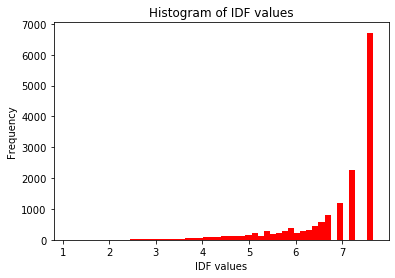

In [187]:

p=IDFDict.values()
num_bins = 50
n, bins, patches = plt.hist(p, num_bins, facecolor='red')
plt.title('Histogram of IDF values')
plt.xlabel('IDF values')
plt.ylabel('Frequency')
plt.show()


### Part 6

In [188]:
def getWordFrequencies(DF):
    vectorizer = CountVectorizer(inputCol="tokenised_description", outputCol="features").fit(DF)
    wordFreqDict = Counter()
    for row in combinedText.collect():
        for word in row['tokenised_description']:
            wordFreqDict[word]+=1
    return dict(wordFreqDict)





In [189]:
wordFreqDict = getWordFrequencies(combinedText)
wordFreqDict

{'learning': 300,
 'quickbooks': 257,
 '2007': 400,
 'fun': 250,
 'reading': 109,
 'writing': 90,
 'designed': 334,
 'help': 513,
 'kids': 129,
 'learn': 235,
 'read': 40,
 'write': 64,
 'better': 227,
 'exercises': 48,
 'puzzle': 70,
 'solving': 26,
 'creative': 804,
 'decoding': 2,
 'qb': 4,
 'pos': 18,
 '6': 332,
 '0': 516,
 'basic': 135,
 'retail': 32,
 'mngmt': 2,
 'software': 2630,
 'retailers': 5,
 'need': 560,
 'inventory': 113,
 'sales': 126,
 'customer': 138,
 'tracking': 63,
 'save': 282,
 'spectacle': 5,
 'city': 50,
 'disrupting': 6,
 'randall': 2,
 'underling': 2,
 's': 1716,
 'plan': 167,
 'drive': 270,
 'stores': 19,
 'business': 735,
 'take': 330,
 'solve': 31,
 'real': 287,
 'world': 435,
 'math': 143,
 'challenges': 62,
 'uniquely': 12,
 'entertaining': 35,
 'make': 539,
 'theme': 56,
 'successful': 20,
 'adobe': 2967,
 'cs3': 1778,
 'production': 574,
 'premium': 399,
 'mac': 900,
 'upgrade': 149,
 'studio': 405,
 'standard': 563,
 'corel': 102,
 'video': 1262,
 '11

In [190]:
TFIDFDict = {word:wordFreqDict[word]*IDFDict[word] for word in wordFreqDict}
TFIDFDict

{'learning': 934.6855078221461,
 'quickbooks': 1128.834083129988,
 '2007': 1265.6581601207254,
 'fun': 766.0812662549007,
 'reading': 446.89591844336934,
 'writing': 371.5682334273342,
 'designed': 920.7846820007285,
 'help': 1329.286271228501,
 'kids': 510.31409077513683,
 'learn': 742.2793999553484,
 'read': 192.29177480312902,
 'write': 273.1710636381145,
 'better': 759.3973090088664,
 'exercises': 215.58918819166794,
 'puzzle': 317.3800724554981,
 'solving': 134.79930363171204,
 'creative': 2484.0728698951298,
 'decoding': 14.528060285799059,
 'qb': 27.012818076534156,
 'pos': 113.09761601798046,
 '6': 982.7083964988594,
 '0': 1346.7960130548754,
 'basic': 508.61554849346163,
 'retail': 163.34546859347702,
 'mngmt': 14.528060285799059,
 'software': 2975.4647736412635,
 'retailers': 32.85441481169792,
 'need': 1427.1666638558409,
 'inventory': 549.8732403214309,
 'sales': 625.1420762880911,
 'customer': 608.7730223920973,
 'tracking': 272.1342433151846,
 'save': 906.6717232406805,
 